# Simple MIGA cavity lock

We begin with some imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from efield import EField, efields
import fftcavity1d.cavities as cavities
from fftcavity1d.cavityhandler import CavityHandler

We define our input field. It will be a simple Gaussian beam.

We make the simulation *radial*. By this we mean that there will be a circular symmetry. Essentially, all powers will be calculated by integrating 2 pi x I(x) from the center of the x array. In this case, no transverse effects such as tilts or misalignments can be taken in account.

In [37]:
win = 0.235e-3
lda = 852e-9
radial = False
nx = 2**12
xm = 5 * win
x = np.linspace(-xm, xm, nx)
E_in = efields.hg_efield(
    n=4, x=x, w=win, normalize_power=True,
    x0=0, lda=lda, radial=radial,
)
# E_in = efields.lg_efield(
#     1, x, win,
#     lda=lda, radial=radial,
#     normalize_power=True,
# )

1.0


We define our MIGA cavity and we misalign it by 12 mm and 3 mm. We define a handler which will take care of finding resonances and storing propagated fields.

In [30]:
f = 0.2
cavity = cavities.MIGACavity(f=f, d1=f, d2=f,
                             R1=0.99, R2=0.99, TL=1.0 - 0.0e-3)
cavity.S2.distance += 12e-3
cavity.S1.distance += 12e-3

handler = CavityHandler(cavity, radial=True)

We define the number of round trips as 2 times the Finesse of the cavity.
Then we ask the handler to calculate the fields for this number of round trips.

Finally, we find the resonances of the cavity with some constraints : the maximum number of resonances to find, the gain threshold of the resonances.

We also pass n_init and eps to the *compute_resonances* method. They define how many points the initial lookup must use, and in what area around a maxima the optimizer has to find a resonance. This can be tuned so that to different maxima do not lead to the same resonance.

In [35]:
n_roundtrips = int(2 * cavity.finess)

print('Finding resonances.')
handler.calculate_fields(E_in, N=n_roundtrips)
resonance_phases = handler.compute_resonances(n_res=3, gain_thres=0.002, n_init=500) #, eps=0.005)

print(resonance_phases)

print('Maximum gain : {0:.1f}'.format(handler.power(resonance_phases[0])))
print('Resonances at :')
print(resonance_phases)

Finding resonances.
[4.648003290365614]
Maximum gain : 0.1
Resonances at :
[4.648003290365614]


Finally we plot the spectrum, with vertical lines showing the peaks, and the shape of the resonating modes.

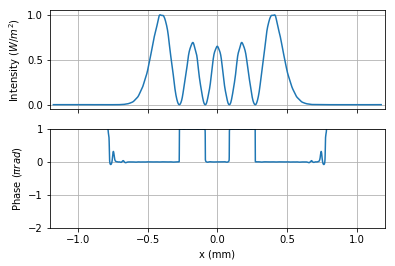

In [36]:
fig, ax = plt.subplots()
handler.plot_spectrum(ax=ax, show_resonances=True, color='k')
#m, M = min(resonance_phases), max(resonance_phases)
#spread = M-m
#ax.set_xlim(m - spread, M + spread)
ax.grid(which='both')
ax.grid(which='minor', color=[0.9] * 3)
ax.set_xlabel('Phase (rad)')
ax.set_ylabel('Optical Gain')

fig, (ax_i, ax_p) = EField.create_figure()
for num, p in enumerate(resonance_phases):
    handler.efield_at(p).plot(fig=fig, normalize=True,
                              label='Mode {0}'.format(num))
ax_p.set_ylim(-2, 1)
ax_i.set_xlim(-1.2, 1.2)

plt.show()